## Notebook Settings



In [1]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

%run /home/leon/dual_task/dual_data/notebooks/setup.py
%matplotlib inline
%config InlineBackend.figure_format = 'png'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Python exe
/home/leon/mambaforge/envs/dual_data/bin/python

## Imports



In [1]:
import sys
  sys.path.insert(0, '/home/leon/dual_task/dual_data/')

  import pickle as pkl
  import numpy as np
  import matplotlib.pyplot as plt
  from scipy.stats import circmean
  from time import perf_counter

  import torch
  import torch.nn as nn
  import torch.optim as optim
  from skorch import NeuralNetClassifier

  from sklearn.base import clone
  from sklearn.model_selection import StratifiedKFold
  from sklearn.model_selection import cross_val_score, cross_validate
  from sklearn.ensemble import BaggingClassifier
  from sklearn.preprocessing import StandardScaler, RobustScaler
  from sklearn.pipeline import Pipeline
  from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, RepeatedStratifiedKFold, StratifiedKFold

  import statsmodels.api as sm
  import statsmodels.formula.api as smf
  import pandas as pd

  from mne.decoding import SlidingEstimator, cross_val_multiscore, GeneralizingEstimator
  from src.decode.my_mne import my_cross_val_multiscore
  from mne.decoding import SlidingEstimator, get_coef

  from src.common.plot_utils import add_vlines, add_vdashed
  from src.attractor.energy import run_energy, plot_energy
  from src.common.options import set_options
  from src.stats.bootstrap import my_boots_ci
  from src.decode.bump import decode_bump, circcvl
  from src.common.get_data import get_X_y_days, get_X_y_S1_S2
  from src.preprocess.helpers import avg_epochs

  import torch.optim as optim
  from torch.utils.data import Dataset, TensorDataset, DataLoader

## Helpers



### Statistics



In [1]:
from scipy.stats import bootstrap

  def get_bootstrap_ci(data, statistic=np.mean, confidence_level=0.95, n_resamples=1000, random_state=None):
      result = bootstrap((data,), statistic)
      ci_lower, ci_upper = result.confidence_interval
      return ci_lower, ci_upper

## Data



### New setup



In [1]:
from scipy.io import loadmat
  import mat73

  path = "/home/leon/dual_task/dual_data/data"
  mouse = "AP02"
  data = mat73.loadmat(path + "/" + mouse + "/dataProcessed.mat")

In [1]:
print(data.keys())

dict_keys(['AllAll', 'AllCorrect', 'AllWrong', 'CdecMean', 'CdecMeanAllNorm', 'CdecMeanNorm', 'CdecSEM', 'CdecSEMAllNorm', 'CdecSEMNorm', 'Cdec_Mice', 'Cdf_Mice', 'D1All', 'D1Correct', 'D1OffAll', 'D1OffCorrect', 'D1OffWrong', 'D1OnAll', 'D1OnCorrect', 'D1OnWrong', 'D1Wrong', 'D2All', 'D2Correct', 'D2OffAll', 'D2OffCorrect', 'D2OffWrong', 'D2OnAll', 'D2OnCorrect', 'D2OnWrong', 'D2Wrong', 'D3All', 'D3Correct', 'D3OffAll', 'D3OffCorrect', 'D3OffWrong', 'D3OnAll', 'D3OnCorrect', 'D3OnWrong', 'D3Wrong', 'D4All', 'D4Correct', 'D4OffAll', 'D4OffCorrect', 'D4OffWrong', 'D4OnAll', 'D4OnCorrect', 'D4OnWrong', 'D4Wrong', 'DD1All', 'DD1Correct', 'DD1OffAll', 'DD1OffCorrect', 'DD1OffWrong', 'DD1OnAll', 'DD1OnCorrect', 'DD1OnWrong', 'DD1Wrong', 'DD2All', 'DD2Correct', 'DD2OffAll', 'DD2OffCorrect', 'DD2OffWrong', 'DD2OnAll', 'DD2OnCorrect', 'DD2OnWrong', 'DD2Wrong', 'DD3All', 'DD3Correct', 'DD3OffAll', 'DD3OffCorrect', 'DD3OffWrong', 'DD3OnAll', 'DD3OnCorrect', 'DD3OnWrong', 'DD3Wrong', 'DD4All', 'D

In [1]:
print(data['trialPerBlock']*2)
print(data['trialPerDay'])
print(data['trialMice'])
print(data['blockPerDay'])
print(2*176)

176.0
176.0
176.0
2.0
352

In [1]:
print(len(data['S1All'][0]))
print(len(data['S2All'][0]))
print(len(data['S3All'][0]))
print(len(data['S4All'][0]))

420
420
420
420

In [1]:
84*5

420

In [1]:
print(len(data['S1NDAll'][0]))
print(len(data['S2NDAll'][0]))
print(len(data['S3NDAll'][0]))
print(len(data['S4NDAll'][0]))

84
84
84
84

In [1]:
print(len(data['S1D1All'][0]))
print(len(data['S2D2All'][0]))
print(len(data['S3D3All'][0]))
print(data['S4D4All'][0])

84
84
84
[  43.   64.   70.   75.  119.  140.  156.  170.  210.  228.  245.  259.
  272.  285.  293.  342.  376.  392.  398.  406.  465.  471.  496.  517.
  564.  581.  591.  603.  618.  629.  646.  698.  708.  719.  755.  768.
  820.  835.  848.  865.  881.  895.  906.  910.  972. 1001. 1033. 1039.
 1072. 1115. 1134. 1136. 1153. 1154. 1184. 1202. 1265. 1281. 1297. 1300.
 1326. 1379. 1388. 1400. 1422. 1438. 1440. 1447. 1498. 1532. 1539. 1580.
 1591. 1630. 1658. 1668. 1696. 1700. 1708. 1751. 1771. 1786. 1802. 1848.]

In [1]:
print(len(data['D1All'][0]))
print(len(data['D2All'][0]))
print(len(data['D3All'][0]))
print(len(data['D4All'][0]))

336
336
336
336

In [1]:
print(np.sum(data['S1DistAll'][0]==data['D1All'][0]))

22

In [1]:
print(data['D4All'])

#+begin_example
[array([   2.,    4.,   17.,   19.,   31.,   38.,   43.,   45.,   59.,
         64.,   70.,   72.,   75.,   76.,   77.,   86.,   91.,  112.,
        119.,  128.,  133.,  137.,  138.,  140.,  143.,  150.,  152.,
        153.,  156.,  162.,  170.,  175.,  186.,  192.,  197.,  199.,
        210.,  215.,  218.,  226.,  227.,  228.,  244.,  245.,  251.,
        259.,  262.,  263.,  272.,  276.,  279.,  280.,  285.,  293.,
        302.,  303.,  306.,  310.,  315.,  319.,  322.,  334.,  337.,
        342.,  355.,  357.,  359.,  363.,  372.,  376.,  388.,  392.,
        398.,  401.,  405.,  406.,  408.,  412.,  415.,  440.,  459.,
        464.,  465.,  466.,  471.,  478.,  481.,  486.,  495.,  496.,
        497.,  499.,  502.,  512.,  517.,  528.,  533.,  535.,  551.,
        560.,  562.,  564.,  567.,  573.,  575.,  578.,  581.,  582.,
        591.,  598.,  601.,  603.,  618.,  619.,  629.,  631.,  640.,
        642.,  646.,  652.,  654.,  664.,  665.,  669.,  687.,  694.,
   

### ACC



In [1]:
from scipy.io import loadmat

  path = "/home/leon/dual_task/dual_data/data"
  mouse = "ACCM03"
  data = loadmat(path + "/" + mouse + "/SamedROI/" + mouse + "_all_days" + ".mat")

In [1]:
print(data.keys())

dict_keys(['__header__', '__version__', '__globals__', 'FR_Trial', 'basFrame', 'blockPerDay', 'delayFrame', 'delayPeriodFrame', 'frameRate', 'laserTag', 'rewardFrame', 'sampleFrame', 'testFrame', 'trialPerBlock', 'dff_Mice', 'Cdf_Mice', 'Events', 'trialPerDay'])

In [1]:
print(data['Events'].shape[0]/192)

5.0

In [1]:
print(data['blockPerDay'])
  print(data['trialPerBlock'])
  print(data['trialPerDay'])

In [1]:
print(data['dff_Mice'].shape)

(361, 960, 84)

In [1]:
print(data['Events'])

[[17 12  3 ...  0  0  0]
 [18 12  1 ...  0  0  0]
 [17 11  1 ...  0  0  0]
 ...
 [17 11  1 ...  0  0  0]
 [18 11  4 ...  0  0  0]
 [17 12  4 ...  0  0  0]]

In [1]:
print(np.sum(data['Events'][:, 4]==0))

320

## Parameters



In [1]:
DEVICE = 'cuda:1'
  mice = ['ChRM04','JawsM15', 'JawsM18', 'ACCM03', 'ACCM04']
  tasks = ['DPA', 'DualGo', 'DualNoGo']

  kwargs = {
      'mouse': 'JawsM15',
      'trials': '', 'reload': 0, 'data_type': 'dF', 'preprocess': True,
      'scaler_BL': None, 'avg_noise':True, 'unit_var_BL':False,
      'random_state': None, 'T_WINDOW': 0.0,
      'l1_ratio': 0.95, 'DCVL': 0
  }

  options = set_options(**kwargs)

In [1]:
X_days, y_days = get_X_y_days(**options)
    y_days['tasks'] = y_days['tasks'].astype('category')
    #  y_days = y_days[y_days['laser']==0]
    print('X', X_days.shape, 'y', y_days.shape)
    print(y_days.keys())

X (1152, 693, 84) y (1152, 6)
Index(['sample_odor', 'test_odor', 'response', 'tasks', 'laser', 'day'], dtype='object')

## Activity timing



In [1]:
day = 5
  options['day'] = day
  options['task'] = 'DualGo'
  options['T_WINDOW'] = 0.0

  X_data, y_data = get_X_y_S1_S2(X_days, y_days, **options)
  print('data', X_data.shape)

  size = X_data.shape[0] // 2
  X = X_data[:, :, options['bins_LD']].mean(0)
  print('X', X.shape)
  peak_times = np.argmax(X, axis=1)
  idx = np.argsort(peak_times)

  # options['epochs'] = ['LD']
  # X_avg = avg_epochs(X_data, **options).astype('float32').mean(0)
  # idx = np.argsort(X_avg)
  # print(idx.shape)

DATA: FEATURES sample TASK DualGo TRIALS  DAYS 5 LASER 0
data (64, 361, 84)
X (361, 9)

In [1]:
fig, ax = plt.subplots(2, 3, figsize=0.75 * np.array([3 * width, 2 * height]))

  size = X_data.shape[0]

  for i in range(options['n_days'] // 2):
      options['day'] = i+1
      X_data, y_data = get_X_y_S1_S2(X_days, y_days, **options)

      data = circcvl(np.nanmean(X_data[:size, idx], 0), windowSize=2, axis=0)

      ax[0][i].imshow(data,
                      aspect='auto', cmap='viridis',
                      extent=[0, 14, 0, 693],
                      vmin=-0.5, vmax=1.0,
                      )

      add_vlines(ax=ax[0][i])
      add_vlines(ax=ax[0][i])
      add_vlines(ax=ax[0][i])

  for i in range(options['n_days'] // 2, options['n_days']):
      options['day'] = i+1
      X_data, y_data = get_X_y_S1_S2(X_days, y_days, **options)

      data = circcvl(np.nanmean(X_data[:size, idx], 0), windowSize=2, axis=0)
      ax[1][i-3].imshow(data,
                        aspect='auto', cmap='viridis',
                        extent=[0, 14, 0, 693],
                        vmin=-0.5, vmax=1.0,
                      )
      add_vlines(ax=ax[1][i-3])
      add_vlines(ax=ax[1][i-3])
      add_vlines(ax=ax[1][i-3])
  plt.show()

DATA: FEATURES sample TASK DualGo TRIALS  DAYS 1 LASER 0
DATA: FEATURES sample TASK DualGo TRIALS  DAYS 2 LASER 0
DATA: FEATURES sample TASK DualGo TRIALS  DAYS 3 LASER 0
DATA: FEATURES sample TASK DualGo TRIALS  DAYS 4 LASER 0
DATA: FEATURES sample TASK DualGo TRIALS  DAYS 5 LASER 0


## GLM vs Days



In [1]:
X_days, y_days = get_X_y_days(**options)
    y_days['tasks'] = y_days['tasks'].astype('category')
    #  y_days = y_days[y_days['laser']==0]
    print('X', X_days.shape, 'y', y_days.shape)
    print(y_days.keys())

X (1152, 693, 84) y (1152, 6)
Index(['sample_odor', 'test_odor', 'response', 'tasks', 'laser', 'day'], dtype='object')

X<sub>days</sub> is an np array (trials x neurons x timesteps)



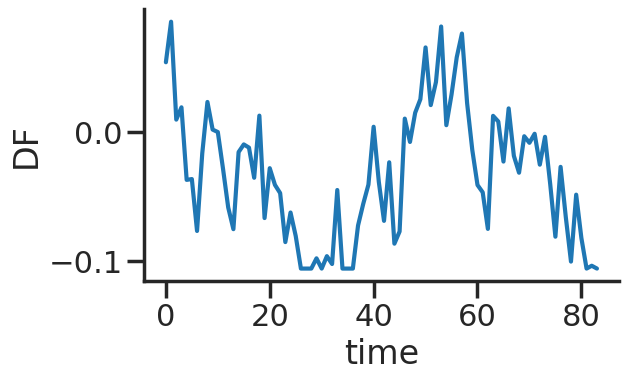

In [1]:
plt.plot(X_days[0, 0])
plt.xlabel('time')
plt.ylabel('DF')
plt.show()

In [1]:
print(y_days.head())

sample_odor  test_odor      response     tasks  laser  day
0          0.0        1.0   correct_rej  DualNoGo    0.0  1.0
1          1.0        0.0  incorrect_fa  DualNoGo    1.0  1.0
2          1.0        0.0   correct_rej    DualGo    0.0  1.0
3          0.0        0.0   correct_hit    DualGo    0.0  1.0
4          1.0        1.0   correct_hit  DualNoGo    1.0  1.0

In [1]:
options['epochs'] = ['ED']
  X_avg = avg_epochs(X_days, **options).astype('float32')
  print('X_avg', X_avg.shape)

X_avg (960, 361)

In [1]:
formula = 'df ~ sample_odor * tasks'
    options['task'] = 'DPA'

    results = []
    for day in range(1, 2): # , options['n_days']+1):
            options['day'] = day
            X, y = get_X_y_S1_S2(X_days, y_days, **options)
            res = []

            # data = y_days
            data = y_days[(y_days['day'] == day) & (y_days['laser']==0) & (y_days['tasks']=='DPA')]
            # print(data.shape)

            for neuron in range(1): #, X_avg.shape[1]): # over neurons
                for time in range(1): #, X_avg.shape[-1]):  # over time
                    data.loc[:, ['df']] = X[:, neuron, time]
                    print(data.head())
                    # glm_gauss = smf.glm(formula=formula, data=data, family=sm.families.Gaussian())
                    # res.append(glm_gauss.fit())

            results.append(res)

X_S1 (16, 693, 84) X_S2 (16, 693, 84)
    sample_odor  test_odor        response tasks  laser  day        df
5           0.0        1.0     correct_rej   DPA    0.0  1.0 -0.113828
8           0.0        0.0  incorrect_miss   DPA    0.0  1.0 -0.042089
14          1.0        1.0     correct_hit   DPA    0.0  1.0  0.089193
21          1.0        0.0    incorrect_fa   DPA    0.0  1.0 -0.014657
25          1.0        1.0     correct_hit   DPA    0.0  1.0 -0.004175

In [1]:
results = np.array(results)

In [1]:
print(results[0][2].summary())

#+begin_example
                   Generalized Linear Model Regression Results
  Dep. Variable:                     df   No. Observations:                   64
  Model:                            GLM   Df Residuals:                       62
  Model Family:                Gaussian   Df Model:                            1
  Link Function:               Identity   Scale:                          5.3946
  Method:                          IRLS   Log-Likelihood:                -143.73
  Date:                Mon, 22 Jul 2024   Deviance:                       334.46
  Time:                        13:01:05   Pearson chi2:                     334.
  No. Iterations:                     3   Pseudo R-squ. (CS):           0.009346
  Covariance Type:            nonrobust
                                      coef    std err          z      P>|z|      [0.025      0.975]
  -------------------------------------------------------------------------------------------------
  Intercept                      

In [1]:
selective = []
    beta = []
    for day in range(options['n_days']):
        sel = []
        bet = []
        for neuron in range(X_avg.shape[1]-1):
            p_value = results[day, neuron].pvalues['sample_odor']
            if p_value < 0.05:
                sel.append(neuron)
            bet.append(results[day, neuron].params['sample_odor'])
        selective.append(sel)
        beta.append(bet)

In [1]:
print(selective[0])
  print(selective[-1])

[19, 110, 113, 129, 134, 148, 154, 170, 210, 229, 244, 268, 306, 333, 341]
[22, 79, 80, 104, 158, 227, 233, 252, 253, 265, 282, 290]

In [1]:
sparse = []
  for i in range(options['n_days']):
      sparse.append(len(selective[i]))

In [1]:
plt.plot(sparse)

| <matplotlib.lines.Line2D | at | 0x7f0220323c90> |


In [1]:
print(beta[0])
  print(beta[-1])

# [goto error]
---------------------------------------------------------------------------
IndexError                                Traceback (most recent call last)
Cell In[135], line 1
----> 1 print(beta[0])
      2 print(beta[-1])
:
IndexError: list index out of range

In [1]:
idx = np.array(beta[-1]).argsort()
  # print(np.array(beta[-1])[idx])

In [1]:
day = options['n_days']
  options['day'] = day
  fig, ax = plt.subplots(1, 2, figsize=[2*width, height])
  X_data, y_data = get_X_y_S1_S2(X_days, y_days, **options)
  print(X_data.shape)

  size = X_data.shape[0] // 2

  data = circcvl(np.nanmean(X_data[:size, idx], 0), windowSize=10, axis=0)

  ax[0].imshow(data,
            aspect='auto', cmap='jet',
            extent=[0, 14, 0, len(selective[day-1])],
            vmin=-0.5, vmax=1.5,
            interpolation='lanczos')

  data = circcvl(np.nanmean(X_data[size:, idx], 0), windowSize=10, axis=0)

  ax[1].imshow(data,
            aspect='auto', cmap='jet',
            extent=[0, 14, 0, len(selective[day-1])],
            vmin=-0.5, vmax=1.5,
            interpolation='lanczos')

  # add_vdashed(ax)
  # cb = ax.set_colorbar()
  # cb.set_label('$\Delta F / F$')

  ax[0].set_xticks(np.arange(0, 16, 4))
  ax[0].set_xlabel('Time')
  ax[0].set_ylabel('Neuron')

  plt.show()

DATA: FEATURES sample TASK DPA TRIALS  DAYS 5 LASER 0
(64, 361, 84)


In [1]:
fig, ax = plt.subplots(2, 3, figsize=0.75 * np.array([3 * width, 2 * height]))

  size = X_data.shape[0]

  for i in range(options['n_days'] // 2):
      options['day'] = i+1
      X_data, y_data = get_X_y_S1_S2(X_days, y_days, **options)

      data = circcvl(np.nanmean(X_data[:size, idx], 0), windowSize=10, axis=0)

      ax[0][i].imshow(data,
                      aspect='auto', cmap='jet',
                      extent=[0, 14, 0, 693],
                      vmin=-0.5, vmax=1.5,
                      )

      add_vlines(ax=ax[0][i])
      add_vlines(ax=ax[0][i])
      add_vlines(ax=ax[0][i])

  for i in range(options['n_days'] // 2, options['n_days']):
      options['day'] = i+1
      X_data, y_data = get_X_y_S1_S2(X_days, y_days, **options)

      data = circcvl(np.nanmean(X_data[:size, idx], 0), windowSize=10, axis=0)
      ax[1][i-3].imshow(data,
                        aspect='auto', cmap='jet',
                        extent=[0, 14, 0, 693],
                        vmin=-0.5, vmax=1.5,
                      )
      add_vlines(ax=ax[1][i-3])
      add_vlines(ax=ax[1][i-3])
      add_vlines(ax=ax[1][i-3])
  plt.show()

DATA: FEATURES sample TASK DPA TRIALS  DAYS 1 LASER 0
DATA: FEATURES sample TASK DPA TRIALS  DAYS 2 LASER 0
DATA: FEATURES sample TASK DPA TRIALS  DAYS 3 LASER 0
DATA: FEATURES sample TASK DPA TRIALS  DAYS 4 LASER 0
DATA: FEATURES sample TASK DPA TRIALS  DAYS 5 LASER 0


## Data



In [1]:
X_days, y_days = get_X_y_days(**options)
  y_days['tasks'] = y_days['tasks'].astype('category')
  # y_days = y_days[y_days['laser']==0]

  options['day'] = 1
  X_data, y_data = get_X_y_S1_S2(X_days, y_days, **options)

#+begin_example
  Reading data from source file
  mouse JawsM15 n_days 6 day 1 type dF all data: X (192, 693, 84) y (9, 192)
  mouse JawsM15 n_days 6 day 2 type dF all data: X (192, 693, 84) y (9, 192)
  mouse JawsM15 n_days 6 day 3 type dF all data: X (192, 693, 84) y (9, 192)
  mouse JawsM15 n_days 6 day 4 type dF all data: X (192, 693, 84) y (9, 192)
  mouse JawsM15 n_days 6 day 5 type dF all data: X (192, 693, 84) y (9, 192)
  mouse JawsM15 n_days 6 day 6 type dF all data: X (192, 693, 84) y (9, 192)
  ##########################################
  PREPROCESSING: SCALER None AVG MEAN False AVG NOISE True UNIT VAR False
  ##########################################
  DATA: FEATURES sample TASK DualGo TRIALS  DAYS 1 LASER 0
#+end_example

In [1]:
plt.plot(X_data[:10, 1].T, alpha=.5)
  plt.show()

## GLM



In [1]:
import statsmodels.api as sm
  import statsmodels.formula.api as smf
  import pandas as pd

In [1]:
print(X_days.shape, y_days.shape)

(1152, 693, 84) (1152, 6)

In [1]:
print(y_days.keys())

Index(['sample_odor', 'test_odor', 'response', 'tasks', 'laser', 'day'], dtype='object')

In [1]:
print(X_data.shape, y_data.shape)

(32, 693, 84) (32,)

In [1]:
print(X_days.shape)

(1152, 693, 84)

In [1]:
data = y_days

  options['epochs'] = ['ED']
  X_avg = avg_epochs(X_days, **options).astype('float32')
  print(X_avg.shape)

  data['df'] = X_avg[:, 0]
  data['tasks'] = data['tasks'].astype('category')
  print(data.keys())

(1152, 693)
Index(['sample_odor', 'test_odor', 'response', 'tasks', 'laser', 'day', 'df'], dtype='object')

In [1]:
print(data['tasks'].head())

0    DualNoGo
1    DualNoGo
2      DualGo
3      DualGo
4    DualNoGo
Name: tasks, dtype: category
Categories (3, object): ['DPA', 'DualGo', 'DualNoGo']

In [1]:
#  Specify the formula
  formula = 'df ~ sample_odor * tasks'

In [1]:
results = []
  for neuron in range(X_avg.shape[1]):
      data['df'] = X_avg[:, neuron]
      glm_gauss = smf.glm(formula=formula, data=data, family=sm.families.Poisson(link=sm.families.links.log()))
      # glm_gauss = smf.glm(formula=formula, data=data, family=sm.families.Gaussian())
      results.append(glm_gauss.fit())

In [1]:
#  Output the summary of the model
  print(results[3].summary())

#+begin_example
                   Generalized Linear Model Regression Results
  Dep. Variable:                     df   No. Observations:                 1152
  Model:                            GLM   Df Residuals:                     1146
  Model Family:                 Poisson   Df Model:                            5
  Link Function:                    log   Scale:                          1.0000
  Method:                          IRLS   Log-Likelihood:                -92.189
  Date:                Mon, 15 Jul 2024   Deviance:                       78.499
  Time:                        17:45:21   Pearson chi2:                     231.
  No. Iterations:                     6   Pseudo R-squ. (CS):          0.0005789
  Covariance Type:            nonrobust
                                      coef    std err          z      P>|z|      [0.025      0.975]
  -------------------------------------------------------------------------------------------------
  Intercept                      

In [1]:
selective_neuron = []
  for neuron in range(X_avg.shape[1]):
      p_value = results[neuron].pvalues['sample_odor']
      if p_value < 0.05:
          selective_neuron.append(neuron)

In [1]:
print(selective_neuron)

[17, 169, 317, 372, 460, 464, 516, 560, 647]

## Fluorescence



In [1]:
x_time =  np.linspace(0, 14, 84)

In [1]:
# plt.imshow(X_data.mean(1), aspect='auto', cmap='viridis', extent=[0, 14, 0, 30])
  plt.imshow(np.nanmean(X_days, 0), aspect='auto', cmap='jet', extent=[0, 14, 0, 1152], vmax=0.1)

  cb = plt.colorbar()
  cb.set_label('$\Delta F / F$')

  plt.xticks(np.arange(0, 16, 2))
  plt.xlabel('Time')
  plt.ylabel('$\Delta F/F$')
  plt.ylabel('Trial')
  plt.show()